# **PPP Computations**

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

from PIL import Image

%load_ext autoreload
%autoreload 2
import hmei.processing as pcs
import hmei.visualization as vis

# ~~Import Data~~

Necessary data:
* control run variance
* ensemble timeseries

## Southern Ocean

In [3]:
def open_ctrl(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_var.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ctrl_so_var = open_ctrl('sst', 'monthly')
sss_ctrl_so_var = open_ctrl('sss', 'monthly')
mld_ctrl_so_var = open_ctrl('mld', 'monthly')
npp_ctrl_so_var = open_ctrl('npp', 'monthly')
sic_ctrl_so_var = open_ctrl('cn_inv', 'monthly')
sie_ctrl_so_var = open_ctrl('sie', 'monthly')
siv_ctrl_so_var = open_ctrl('siv', 'monthly')

In [4]:
def open_ens(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_anom.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ens_so_anom = open_ens('sst', 'monthly')
sss_ens_so_anom = open_ens('sss', 'monthly')
mld_ens_so_anom = open_ens('mld', 'monthly')
npp_ens_so_anom = open_ens('npp', 'monthly')
sic_ens_so_anom = open_ens('cn_inv', 'monthly')
sie_ens_so_anom = open_ens('sie', 'monthly')
siv_ens_so_anom = open_ens('siv', 'monthly')

## Global

In [5]:
def open_ctrl(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/CTRL/'
    subdir = var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_var.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ctrl_global_var = open_ctrl('sst', 'monthly', reg='global')
sss_ctrl_global_var = open_ctrl('sss', 'monthly', reg='global')
mld_ctrl_global_var = open_ctrl('mld', 'monthly', reg='global')
npp_ctrl_global_var = open_ctrl('npp', 'monthly', reg='global')
sic_ctrl_global_var = open_ctrl('cn_inv', 'monthly', reg='global')
sie_ctrl_global_var = open_ctrl('sie', 'monthly', reg='global')
siv_ctrl_global_var = open_ctrl('siv', 'monthly', reg='global')

In [6]:
def open_ens(var, timescale, reg='so'):
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_anom.nc'
    
    return xr.open_dataset(writedir+subdir+filename)

sst_ens_global_anom = open_ens('sst', 'monthly', reg='global')
sss_ens_global_anom = open_ens('sss', 'monthly', reg='global')
mld_ens_global_anom = open_ens('mld', 'monthly', reg='global')
npp_ens_global_anom = open_ens('npp', 'monthly', reg='global')
sic_ens_global_anom = open_ens('cn_inv', 'monthly', reg='global')
sie_ens_global_anom = open_ens('sie', 'monthly', reg='global')
siv_ens_global_anom = open_ens('siv', 'monthly', reg='global')

# Compute PPP

$$ PPP(t) = 1 - \frac{\frac{1}{N(M - 1)} \sum\limits_{j=1}^{N} \sum\limits_{I=1}^{M} (X_{ij}(t) - \overline{X}_{j}(t))^{2}}{\sigma_{c}^{2}} $$

"where $X_{ij}(t)$ is the value of a given variable for the $j$th ensemble and $i$th ensemble member, $\overline{X}_{j}$ is the mean of the $j$th ensemble over all ensemble members, $\sigma_{c}^{2}$ is the variance of the control simulation, $N$ is the total number of different ensemble simulations ($N$=6) and $M$ the number of ensemble members ($M$=40)" - Froelicher et al. 2020

In [149]:
def comp_ppp(var, reg, save=False, timescale='monthly'):

    ## import necessary data
    writedir = '/home/bbuchovecky/storage/so_predict_derived/'
    
    ## variance of the control simulation for each month
    ## dimensions (month: 12)
    subdir = 'CTRL/'+var.upper()+'/'
    filename = var.lower()+'_ts_'+reg+'_'+timescale+'_var.nc'
    ctrl_var = xr.open_dataset(writedir+subdir+filename)
    
    ## ensemble anomalies
    ## dimensions (nStart: 6, nEns: 40, nT: 120)
    subdir = var.upper()+'_ENSEMBLE/'
    filename = var.lower()+'_ens_'+reg+'_'+timescale+'_anom.nc'
    ens_anom = xr.open_dataset(writedir+subdir+filename)
    
    regions = ctrl_var.data_vars

    ## constants
    N = 6
    M = 40

    ## numerator coefficient
    num_coeff = 1 / (N * (M - 1))

    ## numerator outer sum - across all ensembles
    num_outer_sum = np.zeros((6,120))

    PPP = np.zeros( (len(regions), 120) )

    for (iReg,r) in zip(range(len(regions)), regions):

        for j in range(N):
            ## numerator inner sum - across all ensemble members
            num_inner_sum = np.zeros((40,120))

            ## ensemble mean
            ens_mean = ens_anom[r][j].mean(dim='nEns')

            for i in range(M):
                num_inner_sum[i] = np.square(ens_anom[r][j,i] - ens_mean)

            num_outer_sum[j] = np.sum(num_inner_sum, axis=0)

        ## numerator total sum
        num_sum = np.sum(num_outer_sum, axis=0)

        ## compute PPP
        for m in range(120):
            PPP[iReg][m] = 1 - ( (num_coeff * num_sum[m]) / ctrl_var[r][m%12] )
            
    ## organize PPP data in a Dataset
    PPP_da = []
    for (iReg,r) in zip(range(len(regions)), regions):
        
        PPP_reg = xr.DataArray(
                    data=PPP[iReg],
                    dims=['nT'],
                    coords=dict(
                        nT=np.arange(1,121)
                    ),
                    name=r
                )
        
        PPP_da.append(PPP_reg.copy(deep=True))
    
    PPP_ds = xr.merge(PPP_da)
    PPP_ds.attrs['name'] = var.lower()+'_ts_'+reg+'_'+timescale+'_ppp.nc'
        
    if save:
        subdir = 'PPP/'+var.upper()+'/'
        filename = var.lower()+'_ts_'+reg+'_'+timescale+'_ppp.nc'
        PPP_ds.to_netcdf(writedir+subdir+filename)
        print(writedir+subdir+filename)
        
    elif not save:
        return PPP_ds

In [150]:
variables = ['sst','sss','npp','mld', 'pco2surf', 'cn_inv','sie','siv']
regions = ['global', 'so']

for v in variables:
    for r in regions:
        comp_ppp(v, r, save=True, timescale='monthly')

/home/bbuchovecky/storage/so_predict_derived/PPP/SST/sst_ts_global_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/SST/sst_ts_so_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/SSS/sss_ts_global_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/SSS/sss_ts_so_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/NPP/npp_ts_global_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/NPP/npp_ts_so_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/MLD/mld_ts_global_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/MLD/mld_ts_so_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/PCO2SURF/pco2surf_ts_global_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/PCO2SURF/pco2surf_ts_so_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/CN_INV/cn_inv_ts_global_monthly_ppp.nc
/home/bbuchovecky/storage/so_predict_derived/PPP/CN_INV/cn_inv_ts_so_monthly_ppp.nc
/home/bb

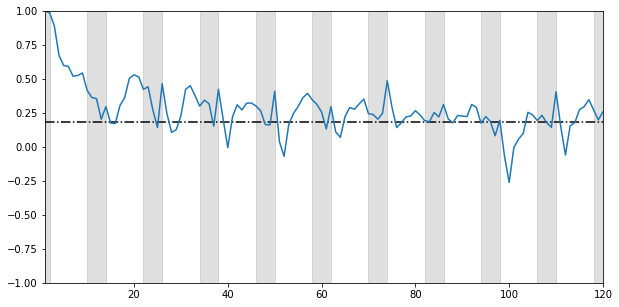

In [168]:
fig,ax = plt.subplots(figsize=(10,5))

ax.plot(np.arange(1,121), comp_ppp('cn_inv', 'so')['Ross'])

for m in np.arange(-2, 120, 12):
    ax.axvspan(m, m+4, color='gray', alpha=0.25)

ax.set_xlim(1,120);
ax.set_ylim(-1,1)

ax.hlines(0.183, 1, 120, color='black', ls='-.')

# Questions

* How well does PPP work with strong seasonal cycles?